In [39]:
from src.utils import utils
import pandas as pd
import numpy as np
from glob import glob
from datasets import Dataset
from datasets import concatenate_datasets, load_from_disk
import json
from os import path
from collections import Counter

In [40]:
causes_of_inflation_ngrams = {
    "demand": ["demand"],
    "supply": ["supply", "energy"],
    "wage": ["wage inflation", "wage spiral", "wage"],
    "monetary": ["monetary policy", "central bank", "monetary"],
    "fiscal": ["policy", "spending", "fiscal"],
    "expect": ["expect", "expectations", "predict"],
    "international": ["exchange rates", "international trade", "global"]
}

effects_of_inflation_ngrams = {
    "purchase": ["purchasing power", "money value"],
    "cost": ["cost", "expense"],
    # "cost": ["savings", "investment", "retirement", "assets"],
    "uncertain": ["uncertainty", "future"],
    "rates": ["interest rates", "rate hike"],
    "redistribution": ["income", "wealth", 'redistribution', 'debt', 'credit'],
    "savings": ["savings", "investment", "retirement", "assets"],
    # "savings":  ["cost", "expense"],
    "trade": ["trade", "export", "import"],
    "cost-push": ["businesses", "profits"],
    "social": ["impact", "political", "social"],
    "govt": ["government", "spending", "budget"]
}

In [41]:
dir_base = f"/data/mourad/narratives/model_json_preds/proquest"
all_ds = []
all_dfs = []
# /data/mourad/narratives/model_json_preds/proquest/llama31_ft__600s_train-now_and_proquest_sample_2
batchfiles = glob(path.join(dir_base, f"llama31_ft__600s_train-now_and_proquest_sample_*"))
# batchefiles = glob(f"/data/mourad/narratives/model_json_preds/{ds.lower()}/phi2_ft_NOW_filtered_sample_*")
for sample, batchfile in enumerate(batchfiles):
    dataset = load_from_disk(batchfile)
    # ds = utils.load_hf_dataset(model=f"phi2_ft_{ds}_filtered_sample_{sample}")
    dataset = dataset.map(lambda e: {'prediction': json.loads(e['completion'])})
    data = dataset.to_pandas()
    data['lens'] = data['text'].apply(lambda x: len(x.split()))
    data = data[data['lens'] <= utils.PROQUEST_MAX_LEN]
    dataset = Dataset.from_pandas(data, preserve_index=False)
    all_ds.append(dataset)
    all_dfs.append(data)
    
dataset = concatenate_datasets(all_ds)
df = pd.concat(all_dfs)


df['narrative'] = df['prediction'].swifter.progress_bar(True).apply(utils.extract_narrative_category) #
df['contains'] = df['narrative'].apply(lambda x: len(x) > 0).astype(int)

/home/mourad/.conda/envs/mourad-econ-py310/lib/python3.10/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
Pandas Apply: 100%|██████████| 710760/710760 [00:05<00:00, 119055.43it/s]


In [42]:
# Combine both dictionaries for easier processing
all_ngrams = {**causes_of_inflation_ngrams, **effects_of_inflation_ngrams}

# Function to count occurrences of n-grams in a single sentence
def count_ngrams_in_sentence(sentence, ngrams_dict):
    counts = Counter()
    for key, ngrams in ngrams_dict.items():
        for ngram in ngrams:
            if ngram in sentence:
                counts[key] += 1
    return counts

In [43]:
# Apply the function to each row in the DataFrame using swifter for parallel processing
df['cause_counts'] = df['text'].swifter.apply(lambda x: count_ngrams_in_sentence(x, causes_of_inflation_ngrams))
df['effect_counts'] = df['text'].swifter.apply(lambda x: count_ngrams_in_sentence(x, effects_of_inflation_ngrams))
sents_per_time = df.groupby('year_month').size()

/home/mourad/.conda/envs/mourad-econ-py310/lib/python3.10/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
Pandas Apply: 100%|██████████| 710760/710760 [00:04<00:00, 143748.55it/s]


In [44]:

# Aggregate the counts across groups defined by 'year_month'
grouped_cause_counts = df.groupby('year_month')['cause_counts'].apply(lambda x: sum(x, Counter()))
grouped_effect_counts = df.groupby('year_month')['effect_counts'].apply(lambda x: sum(x, Counter()))

grouped_cause_counts = grouped_cause_counts.to_frame(name='counts').reset_index(names=['year_month', 'categories'])
grouped_effect_counts = grouped_effect_counts.to_frame(name='counts').reset_index(names=['year_month', 'categories'])

grouped_ngrams = pd.concat([grouped_cause_counts, grouped_effect_counts], axis=0)

grouped_ngrams
# # Print results
# print("Grouped Causes of Inflation Counts:")
# for year_month, counts in grouped_cause_counts.items():
#     print(f"{year_month}: {dict(counts)}")

# print("\nGrouped Effects of Inflation Counts:")
# for year_month, counts in grouped_effect_counts.items():
#     print(f"{year_month}: {dict(counts)}")

,year_month,categories,counts
0,1960-01,supply,21.0
1,1960-01,fiscal,109.0
2,1960-01,expect,40.0
3,1960-01,monetary,25.0
4,1960-01,wage,98.0
...,...,...,...
2515,1980-12,social,217.0
2516,1980-12,rates,614.0
2517,1980-12,savings,265.0
2518,1980-12,purchase,21.0


In [45]:
grouped_narratives = df.groupby('year_month')['narrative'].apply(lambda x: Counter(sum(x, [])))
grouped_narratives = grouped_narratives.to_frame('counts').reset_index(names=['year_month', 'categories'])

grouped_narratives['type'] = 'narratives'
grouped_ngrams['type'] = 'ngrams'

grouped = pd.concat([grouped_narratives, grouped_ngrams], axis=0)

In [46]:
grouped['counts'] = grouped.swifter.apply(lambda x: x['counts'] / sents_per_time[x['year_month']], axis=1)


/home/mourad/.conda/envs/mourad-econ-py310/lib/python3.10/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
Pandas Apply:   0%|          | 0/9324 [00:00<?, ?it/s]

Pandas Apply: 100%|██████████| 9324/9324 [00:00<00:00, 85908.67it/s]


In [47]:
# Convert 'year_month' to datetime
grouped['year_month'] = pd.to_datetime(grouped['year_month'])

# Filter out rows where 'categories' is 'contains_narrative'
grouped = grouped[~grouped['categories'].isin(['other-effect', 'other-cause', 'contains_narrative'])]
# Get unique categories
unique_categories = grouped['categories'].unique()


## TEST:
# category = unique_categories[0]
# # Filter data for the current category
# category_data = grouped[grouped['categories'] == category]

# # Separate data by type
# ngrams_data = category_data[category_data['type'] == 'ngrams']

# print(ngrams_data)
# ngrams_data.groupby('year_month').apply(lambda x: x['counts'] / len(x))


/tmp/ipykernel_3563299/1264476193.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ngrams_data.groupby('year_month').apply(lambda x: x['counts'] / len(x))
/tmp/ipykernel_3563299/1264476193.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ngrams_data.groupby('year_month').apply(lambda x: x['counts'] / len(x))
/tmp/ipykernel_3563299/1264476193.py:24: DeprecationWarning: DataFrameGroupBy.apply operated

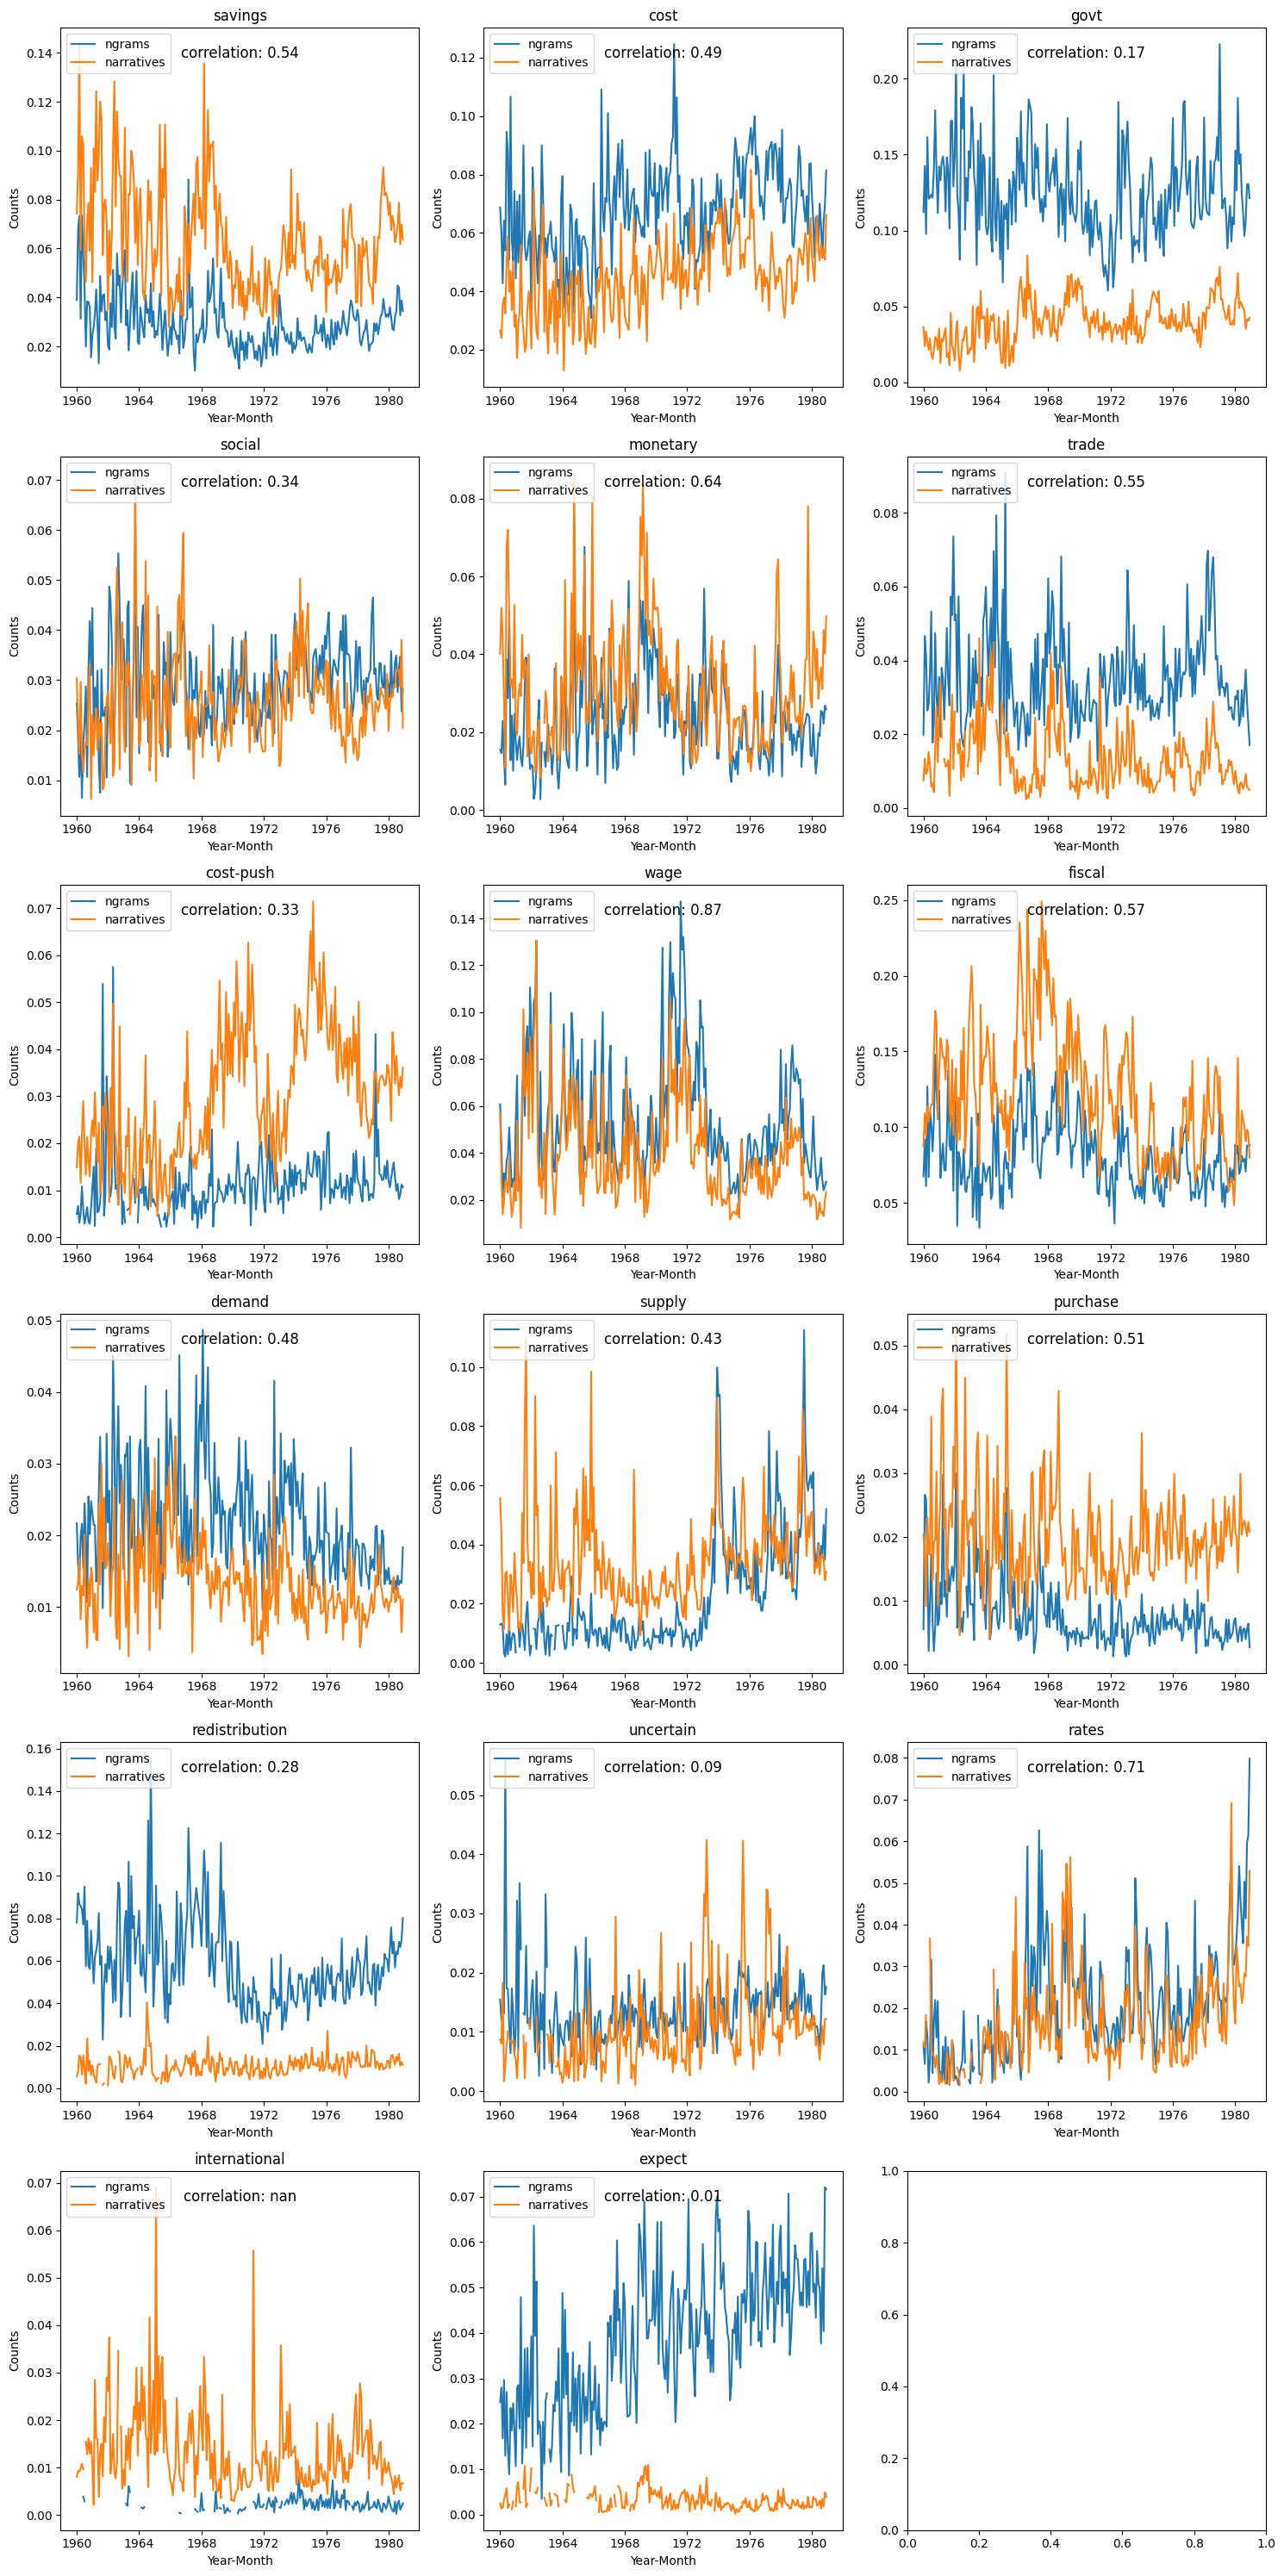

In [49]:
import matplotlib.pyplot as plt

# Determine the number of rows and columns for subplots
n_categories = len(unique_categories)
n_cols = 3
n_rows = (n_categories + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=False, sharey=False)
axes = axes.flatten()

# Plot for each category
for i, category in enumerate(unique_categories):
    ax = axes[i]
    
    # Filter data for the current category
    category_data = grouped[grouped['categories'] == category]
    
    # Separate data by type
    ngrams_data = category_data[category_data['type'] == 'ngrams']
    narratives_data = category_data[category_data['type'] == 'narratives']
    
    # Plot data
    # Calculate proportions
    ngrams_data.groupby('year_month').apply(lambda x: x['counts'] / len(x))
    # ngrams_data['proportion'] = 
    
    # ngrams_data['counts'] / 
    # narratives_data['proportion'] = narratives_data['narrative'] / narratives_data['narrative'].sum()
    

    # Plot proportions
    # ax.plot(ngrams_data['year_month'], ngrams_data['proportion'], label='ngrams', marker=None)
    # ax.plot(narratives_data['year_month'], narratives_data['proportion'], label='narratives', marker=None)
    ax.plot(ngrams_data['year_month'], ngrams_data['counts'], label='ngrams', marker=None)
    ax.plot(narratives_data['year_month'], narratives_data['counts'], label='narratives', marker=None)
    if not ngrams_data.empty and not narratives_data.empty:
        # Interpolate missing values for R^2 calculation
        ngrams_data = ngrams_data.set_index('year_month').reindex(pd.date_range(ngrams_data['year_month'].min(), ngrams_data['year_month'].max(), freq='MS')).interpolate().reset_index()
        narratives_data = narratives_data.set_index('year_month').reindex(pd.date_range(narratives_data['year_month'].min(), narratives_data['year_month'].max(), freq='MS')).interpolate().reset_index()
        
        # Calculate R^2
        r2 = np.corrcoef(ngrams_data['counts'], narratives_data['counts'])[0, 1]# ** 2
        ax.text(0.5, 0.95, f'correlation: {r2:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center')
        # ax.text(0.05, 0.95, f'R^2: {r2:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
    
    # Add title and labels
    ax.set_title(f'{category}')
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Proportion of Sentences')
    ax.legend(loc='upper left')
    ax.grid(False)
    # ax.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.savefig('../../data/plots/narratives_vs_ngrams.pdf', format='pdf', dpi=300)
# plt.show()